In [2]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis')
#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis/computable-information-density')
#from joblib import Parallel, delayed

from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame

In [10]:
base_path = f'Z:\\cid\\na{512}'
os.listdir(base_path) 

act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]
act_list.sort()
act_list

[0.0195, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024]

In [14]:
act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list[1] = 0.21
# sort act_list and act_dir_list by act_list
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]



act_list

[0.0195, 0.21, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023, 0.0235, 0.024]

In [16]:


extract = True

LL = 512
nframes = 32
nexp=5
exp_list = [i for i in range(nexp)]

base_path = f'Z:\\cid\\na{LL}'
outpath = f'data\\nematic\\na{LL}'
if not os.path.exists(outpath):
    os.makedirs(outpath)

act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list.sort()
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]

cid_arr = np.zeros((len(act_list), nexp, 2))
cid_shuffle_arr = np.zeros((len(act_list), nexp, 2))

if extract:

    for i, act_dir in enumerate(act_dir_list):
        exp_dir_list = [os.path.join(act_dir, os.listdir(act_dir)[j]) for j in range(len(os.listdir(act_dir)))]
        exp_dir_list = [x for _, x in sorted(zip(exp_list, exp_dir_list))]
        for j, exp_dir in enumerate(exp_dir_list):
            # load cid.pkl if it exists
            with open(os.path.join(exp_dir, 'cid.pkl'), 'rb') as f:
                cid_dict = pkl.load(f)

            # extract cid values
            cid_arr[i, j, :] = cid_dict['cid']
            cid_shuffle_arr[i, j, :] = cid_dict['cid_shuffle']


Text(0, 0.5, '1 - (CID / CID Shuffle)')

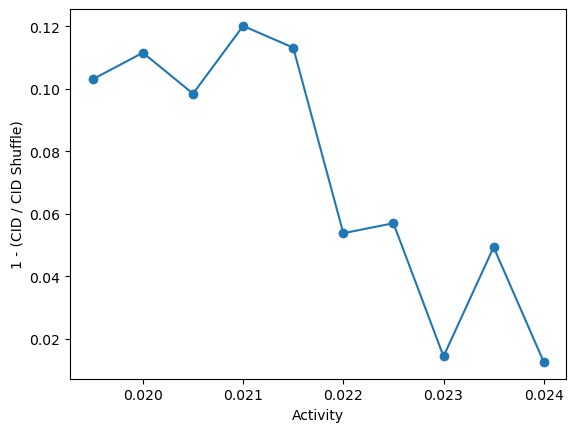

In [36]:
cid_mean = np.mean(cid_arr[:,:,0], axis=1)
cid_std = (np.std(cid_arr[:,:,0], axis=1) + np.mean(cid_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_shuffle_mean = np.mean(cid_shuffle_arr[:,:,0], axis=1)
cid_shuffle_std = (np.std(cid_shuffle_arr[:,:,0], axis=1) + np.mean(cid_shuffle_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_ratio = cid_mean / cid_shuffle_mean
cid_ratio_std = cid_ratio * np.sqrt((cid_std/cid_mean)**2 + (cid_shuffle_std/cid_shuffle_mean)**2)
cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

#plt.errorbar(act_list, cid_shuffle_mean, yerr=cid_shuffle_std, label='CID Shuffle', fmt='o-')   
#plt.errorbar(act_list, cid_mean, yerr=cid_std, label='CID', fmt='o-')
#plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
plt.plot(act_list, 1-cid_ratio, 'o-', label='1 - (CID / CID Shuffle)', )
plt.xlabel('Activity')
plt.ylabel('1 - (CID / CID Shuffle)')